# Лабораторная работа №5

# Применение SSA для декомпозиции временного ряда

## Цыпаев Владимир, гр. РИМ-181228

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

## Этап разложения

In [2]:
def SSA_modes(F, L):
    N = len(F)
    K = N - L + 1
    X = np.empty((L, K)) #траекторная матрица X
    for i in range(L):
        for j in range(K):
            X[i][j]=F[i+j]
    S = np.dot(X, X.T) #полная матрица
    U, A, _ = np.linalg.svd(S) #получение сингулярного разложения, U – матрица собственных векторов, A – массив собственных чисел
    V = np.dot(X.T, U) #матрица траекторных векторов
    return A, U, V

### Проверка функции разложения

In [3]:
ts = np.array([3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 1, 2, 3]) # мини временной ряд
A, U, V = SSA_modes(ts, 3) # его разложение с длиной окна = 3
print("Собственные числа:\n", A, '\n') # собственные числа
print("Собственные вектора:\n", U, '\n') # собственные вектора
print("Траекторные вектора:\n", V, '\n') # траекторные вектора

Собственные числа:
 [129.66842566  12.           3.33157434] 

Собственные вектора:
 [[-5.78869570e-01  7.07106781e-01  4.06091149e-01]
 [-5.74299610e-01  4.14039445e-16 -8.18645196e-01]
 [-5.78869570e-01 -7.07106781e-01  4.06091149e-01]] 

Траекторные вектора:
 [[-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]
 [-4.03837711e+00  8.88178420e-16 -8.31570994e-01]
 [-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]
 [-4.03837711e+00  8.88178420e-16 -8.31570994e-01]
 [-3.46407750e+00  1.41421356e+00 -1.29257973e-02]
 [-2.88977789e+00  0.00000000e+00  8.05719399e-01]
 [-3.46407750e+00 -1.41421356e+00 -1.29257973e-02]] 



## Этап восстановления (группировки)

In [4]:
def SSA_group(A, U, V, N, I):
    L = len(A)
    K = N - L + 1
    #шаг группировки
    V_T = V.transpose()
    Z = np.dot(U[:, I], V_T[I, :])
    #диагональное усреднение
    G = np.zeros(N) #временной ряд исходной длины
    L_st = min(L, K)
    K_st = max(L, K)
    if L>K:
        Z = Z.T
    for k in range(0,L_st-1):
        for m in range(0,k+1):
            G[k]+=(1/(k+1))*Z[m,k-m]
    for k in range(L_st-1, K_st):
        for m in range(0,L_st-1):
            G[k]+=(1/(L_st-1))*Z[m,k-m]
    for k in range(K_st, N):
        for m in range(k-K_st+1,N-K_st+1):
            G[k]+=(1/(N-k))*Z[m,k-m]
    return G

### Проверка функции группировки

In [5]:
ts012 = SSA_group(A, U, V, len(ts), [0, 1, 2])
print(ts012)

[3. 2. 1. 2. 3. 2. 1. 2. 3. 2. 1. 2. 3.]


## Построение отдельных компонент тестового ряда

[2.00524905 1.83111142 1.83242368 2.16355599 2.16224373 1.83111142
 1.83242368 2.16355599 2.16224373 1.83111142 1.83242368 1.83111142
 2.00524905]


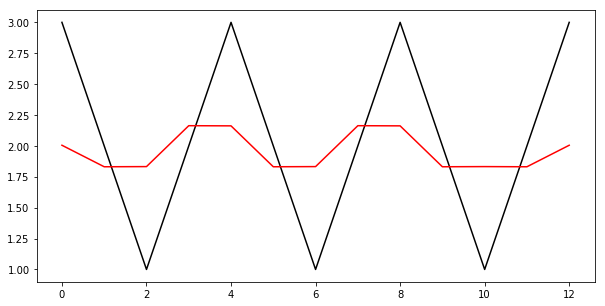

In [6]:
ts0 = SSA_group(A, U, V, len(ts), [0])
print(ts0)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts0, 'r') 
plt.show()

0-компонента содержит некоторое среднее
плавающее значение ряда (тренд)

[ 1.00000000e+00  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01 -2.92770099e-16
  1.00000000e+00]


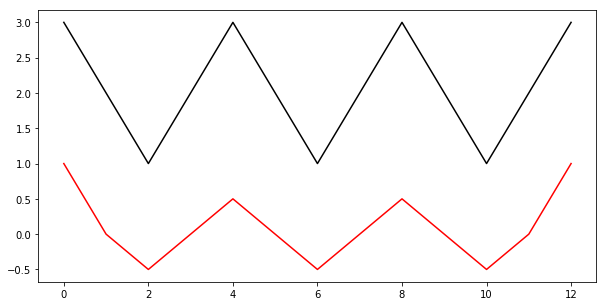

In [7]:
ts1 = SSA_group(A, U, V, len(ts), [1])
print(ts1)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts1, 'r')
plt.show()

[-0.00524905  0.16888858 -0.33242368 -0.16355599  0.33775627  0.16888858
 -0.33242368 -0.16355599  0.33775627  0.16888858 -0.33242368  0.16888858
 -0.00524905]


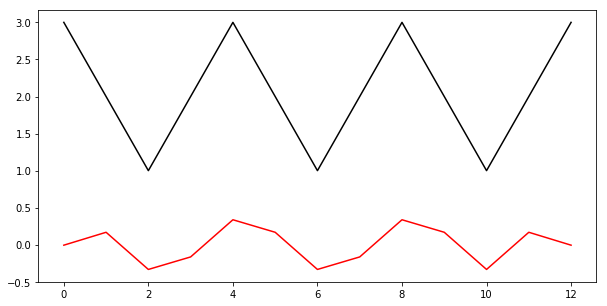

In [8]:
ts2 = SSA_group(A, U, V, len(ts), [2])
print(ts2)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts2, 'r') 
plt.show()

1-компонента и 2-компонента имеют среднее значение близкое к нулю.

1-компонента и 2-компонента имеют одинаковый период, так как любая периодическая составляющая методом SSA всегда разлагается
на парные компоненты.

Амплитуда 1-компоненты выше амплитуды 2-компоненты, так как массив собственных чисел упорядочен по убыванию, то есть с ростом номера компоненты ее «вклад» в исходный ряд уменьшается.

## Построение попарных комбинаций

[3.00524905 1.83111142 1.33242368 2.16355599 2.66224373 1.83111142
 1.33242368 2.16355599 2.66224373 1.83111142 1.33242368 1.83111142
 3.00524905]


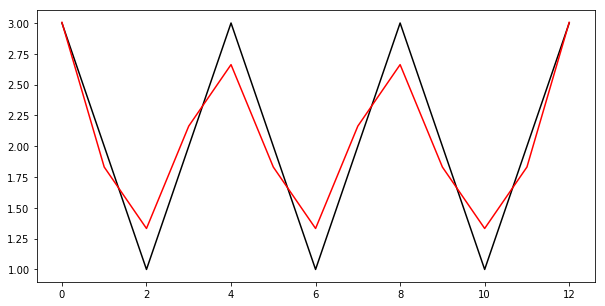

In [9]:
ts01 = SSA_group(A, U, V, len(ts), [0, 1])
print(ts01)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts01, 'r')
plt.show()

[2.  2.  1.5 2.  2.5 2.  1.5 2.  2.5 2.  1.5 2.  2. ]


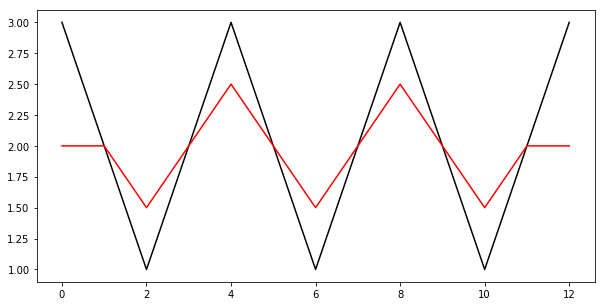

In [10]:
ts02 = SSA_group(A, U, V, len(ts), [0, 2])
print(ts02)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts02, 'r')
plt.show()

[ 0.99475095  0.16888858 -0.83242368 -0.16355599  0.83775627  0.16888858
 -0.83242368 -0.16355599  0.83775627  0.16888858 -0.83242368  0.16888858
  0.99475095]


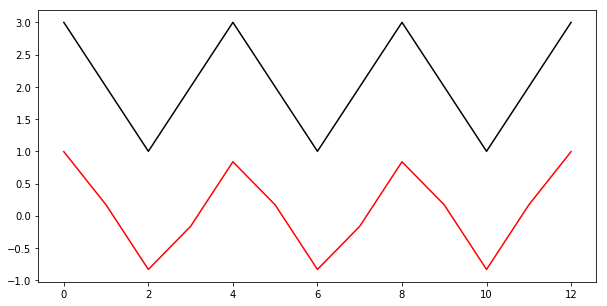

In [11]:
ts12 = SSA_group(A, U, V, len(ts), [1, 2])
print(ts12)

plt.figure(figsize = (10, 5))
plt.plot(ts, 'k')
plt.plot(ts12, 'r')
plt.show()

## Применение SSA к ряду из двух периодик с шумом

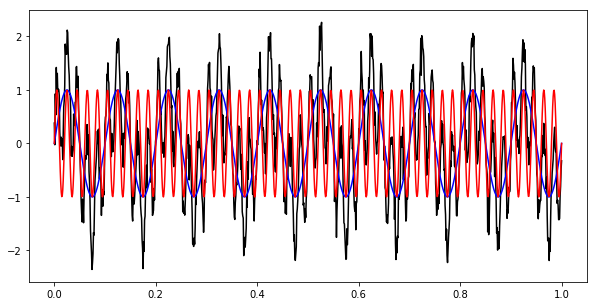

In [12]:
t = np.linspace(0, 1, 1024)
f1 = 10
f2 = 50
F=np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t)+0.2*rand.randn(len(t))
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.show()

### Разложение

In [13]:
A21, U21, V21 = SSA_modes(F, 21) # его разложение с длиной окна = 21
print("Собственные числа:\n", A21, '\n') # собственные числа
print("Собственные вектора:\n", U21, '\n') # собственные вектора
print("Траекторные вектора:\n", V21, '\n') # траекторные вектора

Собственные числа:
 [9355.2479506  5880.54601654 5299.48217055  508.36120664   42.93324592
   41.97116918   41.33766211   41.33498314   40.83477635   40.64786111
   40.19885591   40.09587152   39.36867022   39.18740152   38.16477877
   36.40064945   36.21372856   35.01726679   34.6668512    33.50650916
   32.75107613] 

Собственные вектора:
 [[-1.84441230e-01 -8.34280662e-02  3.12935037e-01 -5.13769671e-01
  -4.03697727e-01  7.98089863e-02  2.79097283e-02 -2.61192797e-02
   1.32613810e-01  1.39799125e-01  7.70080563e-02  1.22572502e-03
  -1.26560521e-01  1.54348918e-02 -4.03938998e-01 -1.60607200e-01
   1.90069029e-01  1.00128205e-01  1.99388859e-02 -3.36256907e-01
  -1.35771019e-01]
 [-1.92607498e-01 -1.56819955e-01  2.93118263e-01 -3.43381315e-01
   1.23872313e-01  3.50769740e-01 -1.51931166e-01  1.43212200e-01
  -4.22581981e-01 -1.00518690e-02 -1.86983749e-01 -1.21032153e-02
   1.46267651e-01  2.14111556e-01  2.71706127e-01  1.61892964e-01
   1.92151009e-01 -1.53224757e-02 -1.775823

### Группировка по компонентам (длина окна 21)

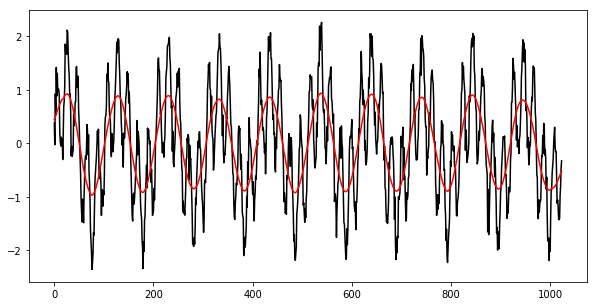

In [14]:
F0_21 = SSA_group(A21, U21, V21, len(F), [0])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F0_21, 'r') 
plt.show()

[ 1.00000000e+00  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01  2.12483924e-17
  5.00000000e-01  2.92770099e-16 -5.00000000e-01 -2.92770099e-16
  1.00000000e+00]


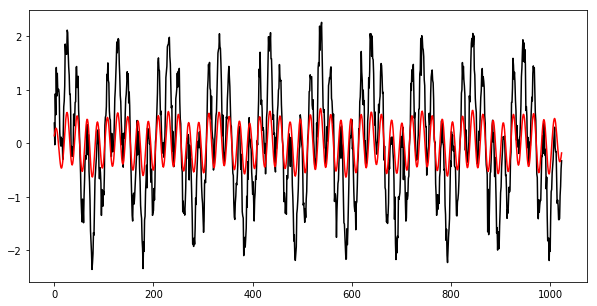

In [15]:
F1_21 = SSA_group(A21, U21, V21, len(F), [1])
print(ts1)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F1_21, 'r')
plt.show()

[-0.00524905  0.16888858 -0.33242368 -0.16355599  0.33775627  0.16888858
 -0.33242368 -0.16355599  0.33775627  0.16888858 -0.33242368  0.16888858
 -0.00524905]


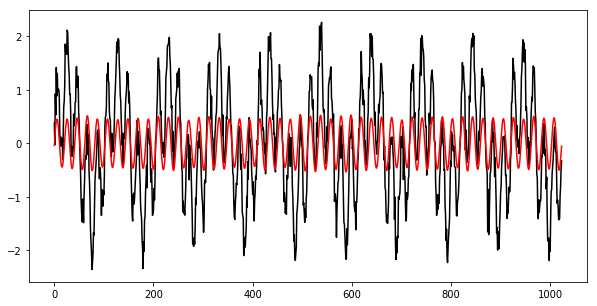

In [16]:
F2_21 = SSA_group(A21, U21, V21, len(F), [2])
print(ts2)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F2_21, 'r') 
plt.show()

[ 0.99475095  0.16888858 -0.83242368 -0.16355599  0.83775627  0.16888858
 -0.83242368 -0.16355599  0.83775627  0.16888858 -0.83242368  0.16888858
  0.99475095]


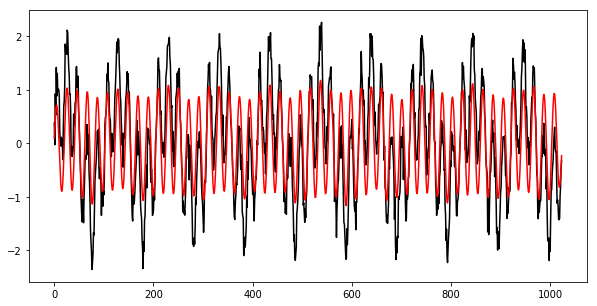

In [17]:
F12_21 = SSA_group(A21, U21, V21, len(F), [1, 2])
print(ts12)

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F12_21, 'r')
plt.show()

### Результаты

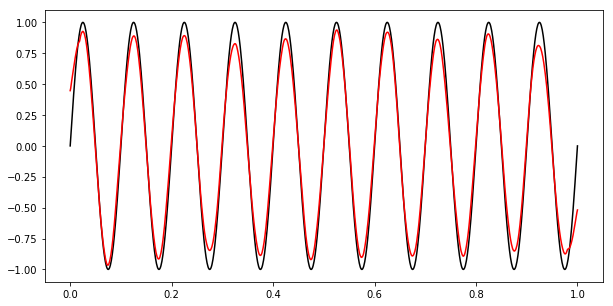

In [18]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f1*t), 'k')
plt.plot(t, F0_21, 'r')
plt.show()

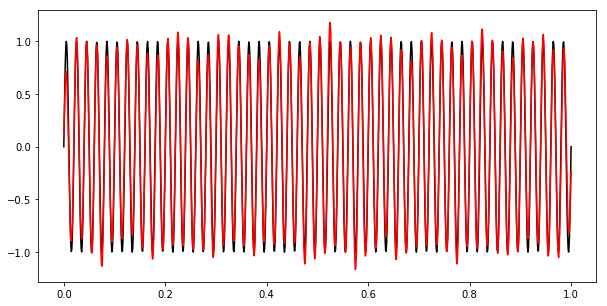

In [19]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f2*t), 'k')
plt.plot(t, F12_21, 'r')
plt.show()

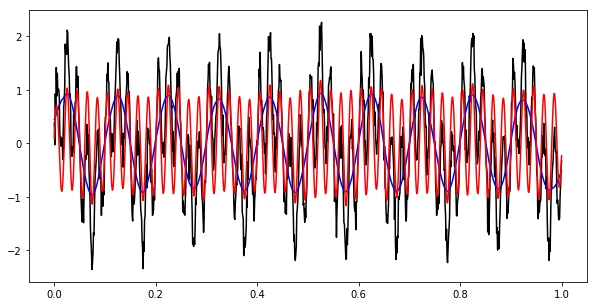

In [20]:
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, F0_21, 'b')
plt.plot(t, F12_21, 'r')
plt.show()

## Применение SSA к сильно зашумленному ряду

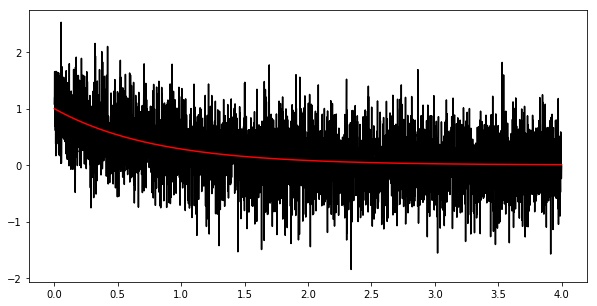

In [21]:
t = np.linspace(0,4,4096)
F = np.exp(-0.4*np.pi*t) + 0.5*rand.randn(len(t))
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.exp(-0.4*np.pi*t), 'r')
plt.show()

### Разложение

In [22]:
A1000, U1000, V1000 = SSA_modes(F,1000) # его разложение с длиной окна = 1000
print("Собственные числа:\n", A1000, '\n') # собственные числа
print("Собственные вектора:\n", U1000, '\n') # собственные вектора
print("Траекторные вектора:\n", V1000, '\n') # траекторные вектора

Собственные числа:
 [1.46573173e+05 2.56215950e+03 2.56025391e+03 2.31809233e+03
 2.28650172e+03 2.18787778e+03 2.18344076e+03 2.14168605e+03
 2.13834215e+03 2.11629169e+03 2.11117187e+03 2.03430314e+03
 2.03033718e+03 1.98596647e+03 1.98224013e+03 1.91412157e+03
 1.91347383e+03 1.83832010e+03 1.83251026e+03 1.80290710e+03
 1.80118035e+03 1.79672166e+03 1.76325221e+03 1.75440739e+03
 1.73888972e+03 1.73334990e+03 1.72663265e+03 1.72526932e+03
 1.72081570e+03 1.70318785e+03 1.70191313e+03 1.69700552e+03
 1.69679376e+03 1.69383687e+03 1.69292626e+03 1.68841845e+03
 1.68462136e+03 1.67369127e+03 1.67223874e+03 1.65501950e+03
 1.65228287e+03 1.65093139e+03 1.65044588e+03 1.64988525e+03
 1.64967535e+03 1.61387536e+03 1.61160392e+03 1.59648833e+03
 1.59428484e+03 1.59247794e+03 1.59240678e+03 1.58876235e+03
 1.57970951e+03 1.57187402e+03 1.57064761e+03 1.54736259e+03
 1.54464534e+03 1.52880837e+03 1.52350881e+03 1.51728795e+03
 1.51281677e+03 1.50636681e+03 1.50487547e+03 1.50120884e+03
 1.5

### Группировка по компонентам (длина окна 1000)

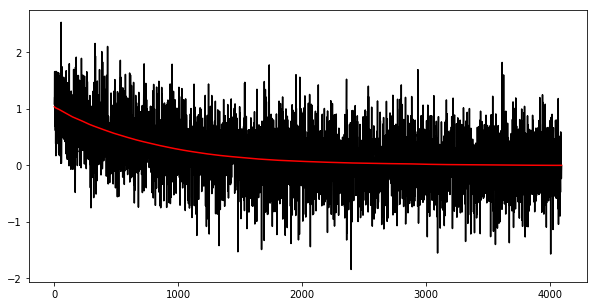

In [23]:
F0_1000 = SSA_group(A1000, U1000, V1000, len(F), [0])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F0_1000, 'r') 
plt.show()

### Результаты

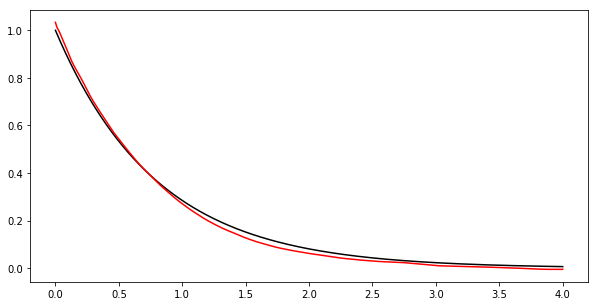

In [24]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.exp(-0.4*np.pi*t), 'k')
plt.plot(t, F0_1000, 'r') 
plt.show()

## Применение SSA к ряду из четырех гармоник с шумом

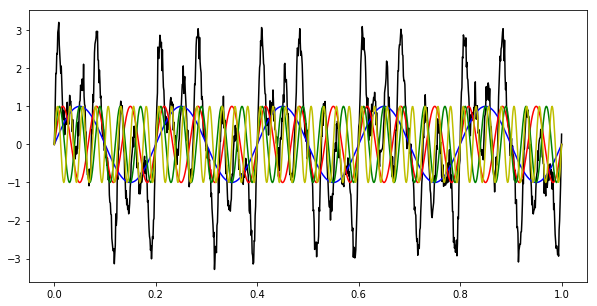

In [25]:
t = np.linspace(0, 1, 1024)
f1 = 5
f2 = 15
f3 = 25
f4 = 40
F=np.sin(2*np.pi*f1*t)+np.sin(2*np.pi*f2*t)+np.sin(2*np.pi*f3*t)+np.sin(2*np.pi*f4*t)+0.2*rand.randn(len(t))
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, np.sin(2*np.pi*f1*t), 'b')
plt.plot(t, np.sin(2*np.pi*f2*t), 'r')
plt.plot(t, np.sin(2*np.pi*f3*t), 'g')
plt.plot(t, np.sin(2*np.pi*f4*t), 'y')
plt.show()

### Разложение

In [26]:
A57, U57, V57 = SSA_modes(F, 57) # его разложение с длиной окна = 57
print("Собственные числа:\n", A57, '\n') # собственные числа
print("Собственные вектора:\n", U57, '\n') # собственные вектора
print("Траекторные вектора:\n", V57, '\n') # траекторные вектора

Собственные числа:
 [2.51663446e+04 2.36886012e+04 2.15911807e+04 1.62104827e+04
 1.55855211e+04 6.49986707e+03 4.40372817e+02 6.43524045e+01
 6.24573950e+01 5.74771527e+01 5.73415404e+01 5.16510886e+01
 5.02845110e+01 4.94972168e+01 4.94522892e+01 4.81140574e+01
 4.77871723e+01 4.72401086e+01 4.69406663e+01 4.55568709e+01
 4.54272096e+01 4.28290422e+01 4.23172833e+01 4.04793300e+01
 4.04237184e+01 3.92527074e+01 3.91569867e+01 3.79756010e+01
 3.79601985e+01 3.74631817e+01 3.69594167e+01 3.58239018e+01
 3.54341058e+01 3.50649504e+01 3.45846937e+01 3.43405911e+01
 3.40257067e+01 3.36906871e+01 3.34487372e+01 3.29780876e+01
 3.29484540e+01 3.23639946e+01 3.21361309e+01 3.18233574e+01
 3.16205097e+01 3.13928970e+01 3.09277824e+01 3.04525902e+01
 3.03232974e+01 2.90495768e+01 2.87843235e+01 2.87561506e+01
 2.83480746e+01 2.63912028e+01 2.61934040e+01 2.52783449e+01
 2.41970471e+01] 

Собственные вектора:
 [[-0.06505086 -0.04431917 -0.15535493 ...  0.12683875 -0.08640468
   0.09584355]
 [-0

### Группировка по компонентам

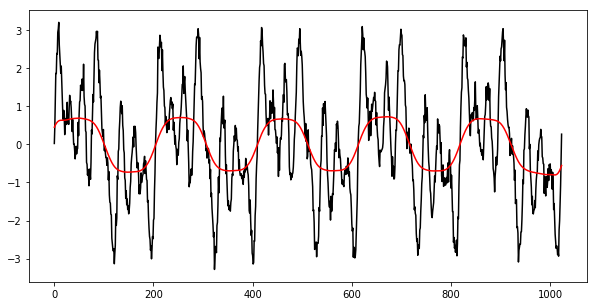

In [27]:
F0_57 = SSA_group(A57, U57, V57, len(F), [0])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F0_57, 'r') 
plt.show()

In [28]:
A60, U60, V60 = SSA_modes(F, 60) # его разложение с длиной окна = 60
print("Собственные числа:\n", A60, '\n') # собственные числа
print("Собственные вектора:\n", U60, '\n') # собственные вектора
print("Траекторные вектора:\n", V60, '\n') # траекторные вектора

Собственные числа:
 [2.53495492e+04 2.36875869e+04 2.27233538e+04 1.62295377e+04
 1.60440823e+04 9.76423830e+03 8.90821853e+02 6.48104045e+01
 6.46611614e+01 5.76039815e+01 5.75013273e+01 5.42906688e+01
 5.17707305e+01 5.15745083e+01 4.98504725e+01 4.82704851e+01
 4.79612396e+01 4.75970841e+01 4.72230540e+01 4.68225245e+01
 4.57694949e+01 4.45321478e+01 4.27180250e+01 4.26977207e+01
 4.09677924e+01 3.98985938e+01 3.93585063e+01 3.91455602e+01
 3.90609821e+01 3.88719966e+01 3.78412817e+01 3.78326983e+01
 3.55681145e+01 3.53004523e+01 3.47087979e+01 3.45359318e+01
 3.44645276e+01 3.42151866e+01 3.39756024e+01 3.37164823e+01
 3.31516161e+01 3.29046953e+01 3.28732107e+01 3.26253063e+01
 3.18035486e+01 3.17427867e+01 3.15595965e+01 3.07078436e+01
 3.06517837e+01 3.00477649e+01 2.95642152e+01 2.95228687e+01
 2.86881721e+01 2.84824311e+01 2.78136679e+01 2.75550927e+01
 2.58926887e+01 2.56980863e+01 2.50414986e+01 2.37645690e+01] 

Собственные вектора:
 [[-0.07878894  0.03148011 -0.12381689 ..

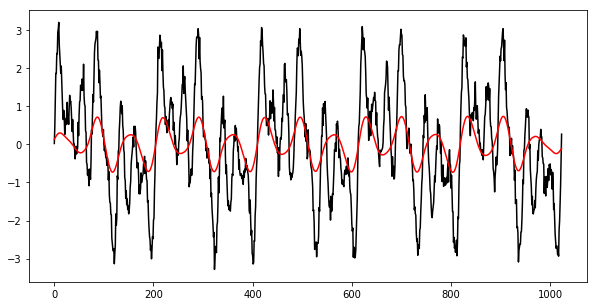

In [29]:
F1_60 = SSA_group(A60, U60, V60, len(F), [1])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F1_60, 'r') 
plt.show()

In [30]:
A65, U65, V65 = SSA_modes(F, 65) # его разложение с длиной окна = 65
print("Собственные числа:\n", A65, '\n') # собственные числа
print("Собственные вектора:\n", U65, '\n') # собственные вектора
print("Траекторные вектора:\n", V65, '\n') # траекторные вектора

Собственные числа:
 [2.56020116e+04 2.36499960e+04 2.35007660e+04 1.63182629e+04
 1.61684060e+04 1.59115449e+04 2.59867654e+03 9.86371789e+01
 6.70655664e+01 6.51827953e+01 5.82026865e+01 5.77076554e+01
 5.53125976e+01 5.42629202e+01 5.26569274e+01 5.17699406e+01
 4.85608234e+01 4.85128895e+01 4.80604475e+01 4.73792374e+01
 4.65104771e+01 4.60991079e+01 4.32829701e+01 4.32050325e+01
 4.13101227e+01 4.12153021e+01 4.07329334e+01 4.01806037e+01
 3.92682108e+01 3.91433557e+01 3.90059217e+01 3.87906871e+01
 3.68317204e+01 3.60528241e+01 3.53286767e+01 3.51516159e+01
 3.49090211e+01 3.43961196e+01 3.43547520e+01 3.43441408e+01
 3.42745078e+01 3.37839014e+01 3.36342282e+01 3.33632263e+01
 3.27544520e+01 3.23525825e+01 3.17685497e+01 3.16032350e+01
 3.15227927e+01 3.11728031e+01 3.07752361e+01 3.01055785e+01
 2.99361179e+01 2.96108287e+01 2.90615869e+01 2.90120872e+01
 2.84005823e+01 2.77102909e+01 2.72066871e+01 2.65265173e+01
 2.63000485e+01 2.46570101e+01 2.45846631e+01 2.41553164e+01
 2.3

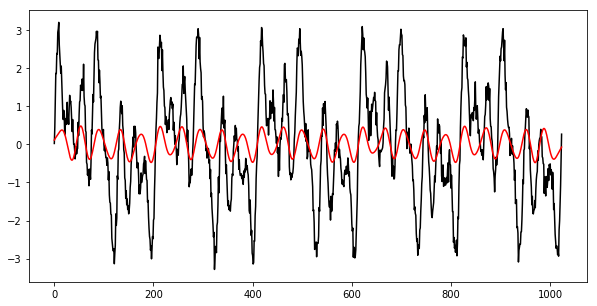

In [31]:
F3_65 = SSA_group(A65, U65, V65, len(F), [3])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F3_65, 'r') 
plt.show()

In [32]:
A75, U75, V75 = SSA_modes(F, 75) # его разложение с длиной окна = 75
print("Собственные числа:\n", A75, '\n') # собственные числа
print("Собственные вектора:\n", U75, '\n') # собственные вектора
print("Траекторные вектора:\n", V75, '\n') # траекторные вектора

Собственные числа:
 [2.52212836e+04 2.41835894e+04 2.36289128e+04 2.35904467e+04
 1.71537687e+04 1.62419490e+04 1.11283686e+04 8.38998204e+02
 6.94347115e+01 6.89758473e+01 6.21666400e+01 6.14279048e+01
 5.61441833e+01 5.59285783e+01 5.38093220e+01 5.37042624e+01
 5.13673357e+01 5.07738283e+01 4.96295207e+01 4.90632097e+01
 4.71210350e+01 4.68158927e+01 4.51269401e+01 4.50791960e+01
 4.50307696e+01 4.43405133e+01 4.15239731e+01 4.06600565e+01
 4.02741512e+01 3.99739590e+01 3.96326762e+01 3.96174971e+01
 3.83535201e+01 3.83026743e+01 3.82082082e+01 3.81589046e+01
 3.77152183e+01 3.63812934e+01 3.57028750e+01 3.56181182e+01
 3.54776880e+01 3.51165537e+01 3.48246538e+01 3.45388545e+01
 3.44874815e+01 3.44380695e+01 3.40567578e+01 3.34620619e+01
 3.32458072e+01 3.30270332e+01 3.29127658e+01 3.26523042e+01
 3.24167750e+01 3.07346042e+01 3.05570423e+01 3.02893167e+01
 3.02607978e+01 2.96171428e+01 2.88973814e+01 2.88298191e+01
 2.86615583e+01 2.83816814e+01 2.81716724e+01 2.76927784e+01
 2.7

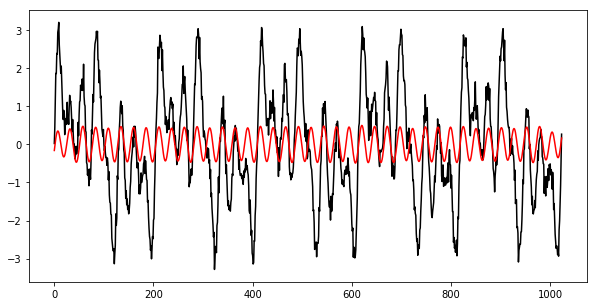

In [33]:
F4_75 = SSA_group(A75, U75, V75, len(F), [4])

plt.figure(figsize = (10, 5))
plt.plot(F, 'k')
plt.plot(F4_75, 'r') 
plt.show()

### Результаты

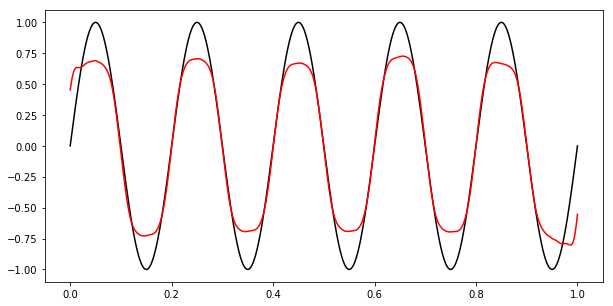

In [34]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f1*t), 'k')
plt.plot(t, F0_57, 'r')
plt.show()

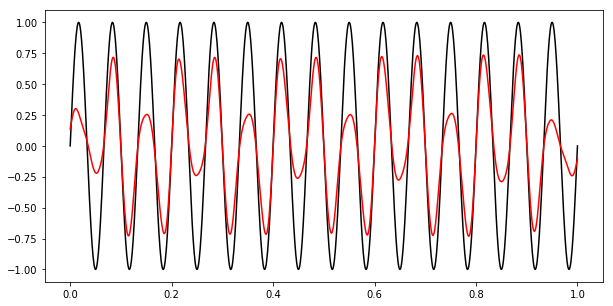

In [35]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f2*t), 'k')
plt.plot(t, F1_60, 'r') 
plt.show()

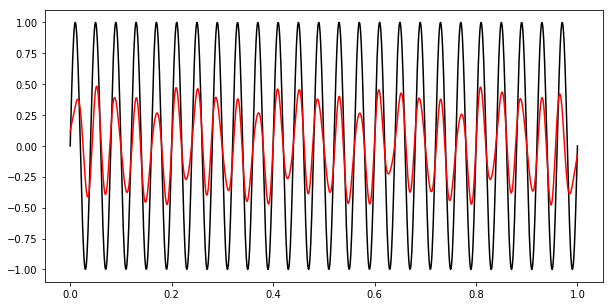

In [36]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f3*t), 'k')
plt.plot(t, F3_65, 'r')
plt.show()

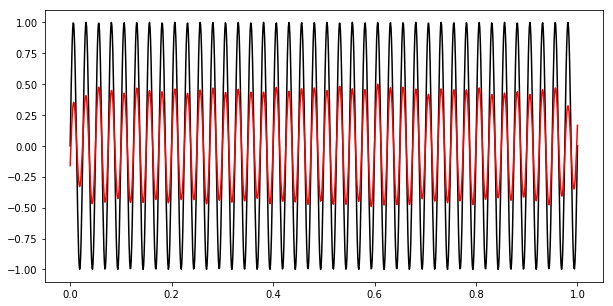

In [37]:
plt.figure(figsize = (10, 5))
plt.plot(t, np.sin(2*np.pi*f4*t), 'k')
plt.plot(t, F4_75, 'r')
plt.show()

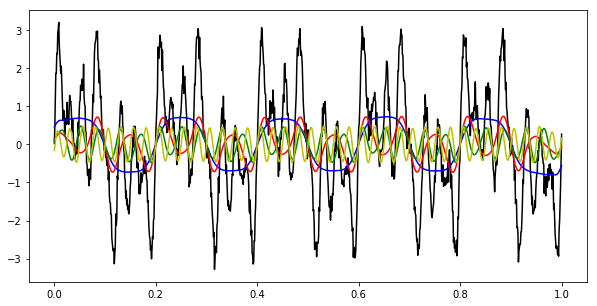

In [38]:
plt.figure(figsize = (10, 5))
plt.plot(t, F, 'k')
plt.plot(t, F0_57, 'b')
plt.plot(t, F1_60, 'r')
plt.plot(t, F3_65, 'g')
plt.plot(t, F4_75, 'y')
plt.show()

## Применение SSA к ряду с изломом частоты

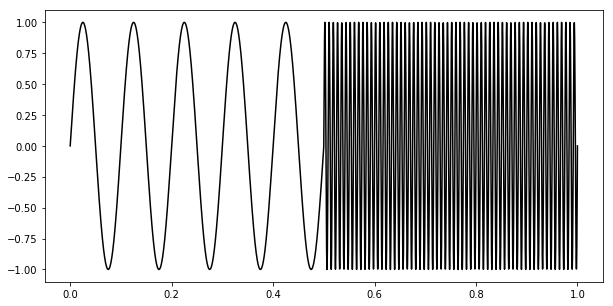

In [39]:
t = np.linspace(0, 1, 4096)
x2 = np.zeros(4096)
for i in range(0, len(t)//2):
    x2[i] = np.sin(2*np.pi*10*t[i])
for i in range(len(t)//2, len(t)):
    x2[i] = np.sin(2*np.pi*120*t[i])
plt.figure(figsize = (10, 5))
plt.plot(t, x2, 'k')
plt.show()

### Разложение

In [40]:
A33, U33, V33 = SSA_modes(x2, 33) # его разложение с длиной окна = 33
print("Собственные числа:\n", A33, '\n') # собственные числа
print("Собственные вектора:\n", U33, '\n') # собственные вектора
print("Траекторные вектора:\n", V33, '\n') # траекторные вектора

Собственные числа:
 [3.31947216e+04 1.78119132e+04 1.60274390e+04 2.50377101e+02
 5.37835401e+00 1.73519935e+00 5.18877253e-01 2.58879760e-01
 1.24848716e-01 7.47034442e-02 4.37810023e-02 2.89193526e-02
 1.88292588e-02 1.32200069e-02 9.17786001e-03 6.70398409e-03
 4.84855693e-03 3.63249849e-03 2.69457112e-03 2.04760942e-03
 1.53867666e-03 1.17366178e-03 8.82719996e-04 6.67838822e-04
 4.95430038e-04 3.65560436e-04 2.61597250e-04 1.82779407e-04
 1.20853621e-04 7.48230121e-05 4.07707457e-05 1.78183101e-05
 4.38685462e-06] 

Собственные вектора:
 [[-0.15599454  0.04986706  0.26557964 ... -0.01798356 -0.01132843
  -0.00593123]
 [-0.15732714  0.0908337   0.25376582 ...  0.07131004  0.04670435
   0.02400296]
 [-0.15905686  0.12907809  0.23403257 ... -0.13794628 -0.09391031
  -0.04832263]
 ...
 [-0.15926854 -0.1400487   0.22855981 ... -0.13794548  0.09390969
  -0.0483223 ]
 [-0.15739    -0.10258795  0.25048008 ...  0.07130883 -0.04670354
   0.02400254]
 [-0.15590169 -0.0619616   0.26458966 ...

### Группировка по компонентам (длина окна 33)

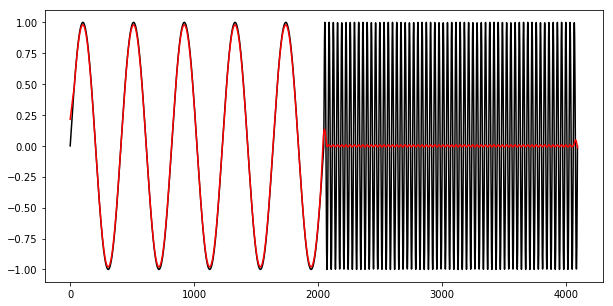

In [41]:
F0_33 = SSA_group(A33, U33, V33, len(x2), [0])

plt.figure(figsize = (10, 5))
plt.plot(x2, 'k')
plt.plot(F0_33, 'r') 
plt.show()

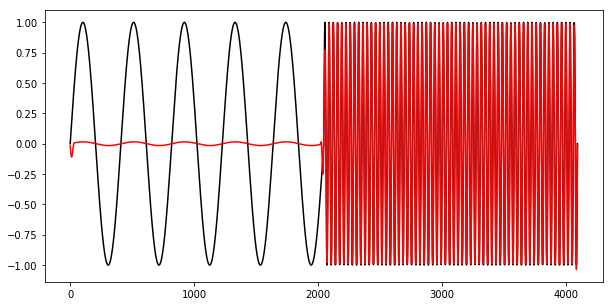

In [42]:
F12_33 = SSA_group(A33, U33, V33, len(x2), [1, 2])

plt.figure(figsize = (10, 5))
plt.plot(x2, 'k')
plt.plot(F12_33, 'r') 
plt.show()

## Применение SSA к ряду из файла

In [43]:
file = h5py.File('lab5.mat','r')
data = file.get('EEG')
eeg = np.array(data).T

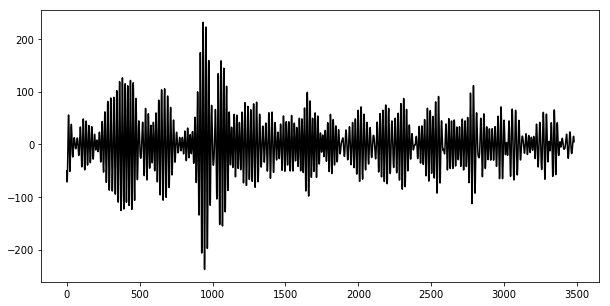

In [44]:
plt.figure(figsize = (10, 5))
plt.plot(eeg, 'k')
plt.show()

### Разложение

In [45]:
A2000, U2000, V2000 = SSA_modes(eeg, 2000) # его разложение с длиной окна = 2000
print("Собственные числа:\n", A2000, '\n') # собственные числа
print("Собственные вектора:\n", U2000, '\n') # собственные вектора
print("Траекторные вектора:\n", V2000, '\n') # траекторные вектора

Собственные числа:
 [6.04699405e+08 6.02332190e+08 4.94156153e+08 ... 3.06824143e-08
 1.75869412e-08 7.22283117e-09] 

Собственные вектора:
 [[-0.02939991 -0.01933127  0.01359299 ... -0.00488269  0.0343171
   0.04840309]
 [-0.03415579 -0.00999518  0.02048404 ... -0.01783793 -0.01313505
  -0.03094931]
 [-0.03578804  0.00039214  0.02484666 ...  0.02697604  0.00148227
   0.02135535]
 ...
 [ 0.01249573  0.00686028  0.00043436 ... -0.01601224  0.0102944
   0.01704154]
 [ 0.01387041  0.00282404  0.00258031 ... -0.00749442  0.0011225
   0.0057575 ]
 [ 0.01393568 -0.00143924  0.00447146 ...  0.00317294 -0.00838346
  -0.00548163]] 

Траекторные вектора:
 [[ 6.34566265e+02 -5.08378406e+02  3.19480353e+02 ... -7.37411199e-09
  -5.34127622e-08  4.40211938e-08]
 [ 7.66402256e+02 -3.06990833e+02  5.39409313e+02 ... -5.20843813e-09
   1.35126068e-07 -1.28040831e-07]
 [ 8.28941350e+02 -7.36983597e+01  6.95251976e+02 ...  1.54399599e-07
  -7.88144716e-08  1.15064523e-07]
 ...
 [ 1.19524953e+02  1.34842

### Группировка по компонентам (длина окна 2000)

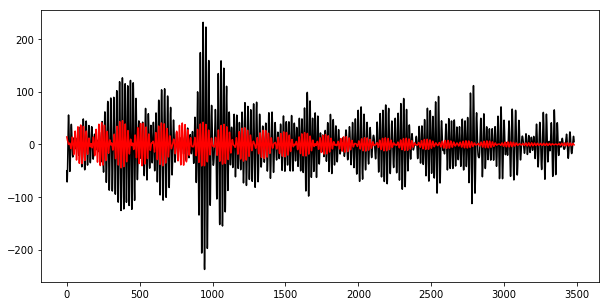

In [49]:
F12_2000 = SSA_group(A2000, U2000, V2000, len(eeg), [1,2])

plt.figure(figsize = (10, 5))
plt.plot(eeg, 'k')
plt.plot(F12_2000, 'r') 
plt.show()